Color Matching
============

The goal of this homework is to develop a color-matching system. You will create ML models that can both predict a color name from an RGB triplet. If you don't know how RGB triplets work, do a little searching on the internet. Our system will use the numbers 0-255 for each value of red, green, and blue.

The dataset simply has one column for each of R, G, and B along with a column for the color names. Ths is derived from the [XKCD Color Suvery](https://blog.xkcd.com/2010/05/03/color-survey-results/). However the data has been highly pre-processing for you:

* Colorblind participant responses have been removed
* Non-english speaking participant responses have been removed
* Non-LCD-monitor-user responses have been removed
* Responses considered to be spammy have been removed
* All unique color names have been removed
* All colornames longer than 32 characters have been removed*
* All characters converted to lowercase and many symbols removed/replaced
* 1000s of spelling mistakes and other corrections to the data have been made to increase the quality of the data dramatically

***WARNING***: Even with all of the data cleaning and sample removal there is still about 2.5 million samples with a total of about 20,000 unique color names. There are definitely still spelling mistakes or colors that could be combined just written slightly differently.

You will not be able to train on the full dataset at once. In fact you will likely only be able to train on about 50,000-100,000 samples at a time depending on your algorithm and data cleaning. Online algorithms that can do mini-batches will be perfect here (see later on for doing this).


Getting the data and data exploration part is mostly done for you:

* The code for grabbing the data is below (note that I may update the data if any agregious problems are found with it)
* The target is the colorname
* The colorname color is a string, it is multiclass categorical
* All of the R, G, B features are integral, ranging from 0 to 255, uniform distributions, and there is no correlation between them and you cannot do meaningful correlations between categorical and numerical features
* No feature is missing data but not all of the data will be useful
* The problem would be solved manually by having an expert gives names to specific RGB values. When prediciting you simply find the nearest RGB value to predict its colorname.

In [1]:
#All imports for the project
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pylab as plt
import colorsys as colorsys

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
from sklearn.svm import LinearSVC



In [2]:
# Load the full dataset
colors_full = pd.read_csv('https://drive.google.com/a/moravian.edu/uc?id=1AYDeEHLe0KvqRIQSaRZcXkXzefSAZZw5&export=download', compression='gzip',
                          dtype={'r':np.uint8, 'g':np.uint8, 'b':np.uint8, 'colorname':str})
colors_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2491728 entries, 0 to 2491727
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   r          uint8 
 1   g          uint8 
 2   b          uint8 
 3   colorname  object
dtypes: object(1), uint8(3)
memory usage: 26.1+ MB


In [3]:
# List the counts for all the colornames (will only show us the highest counting and lowest counting ones)
colors_full.colorname.value_counts()

green                234815
blue                 219401
purple               199072
pink                  98883
brown                 56580
                      ...  
nondescript green         2
savannah grass            2
green varient             2
penguin                   2
thunder gray              2
Name: colorname, Length: 20704, dtype: int64

Big Picture and Get and Explore the Data
-----------------

While the above notes and code get you through most of this, you still must:
* Frame this problem (supervised/unsupervised, online/offline, regression/classification, ...)
* Decide if you will be shuffling your data
 * The data is ordered by time that a person submitted the data which means that one person's samples will all be very close to each other.
* Split a test set but don't worry about stratification
* Identify the promising transformations you may want to apply:
 * Even though we don't have many features and they are all fairly basic you should think about how you may combine them or modify them to get more features that may assist the ML model you choose. You may come back to this step after you have already begun to explore the ML models however.
 * Remember that you want to work with only a subset of the data due to the massive number of samples.

This problem would benefit from a supervised solution. It is a classification problem . Online functionality would be beneficial and mini batches will be used because the data set is large and this works with online models.

We should shuffle the data to make sure each person's answers are not grouped together.

In [4]:
#Shuffling the data
colors_full_shuffled = colors_full.sample(frac=1)

In [5]:
#Splitting off the testing set using train_test_split. Using a random state to produce reproducable results
train_set, test_set = train_test_split(colors_full_shuffled, test_size=0.2, random_state=42)

Using a test set 20% of the full dataset because we are not worried about the size of the training set and having to make it smaller, but 25% (the sklearn default) would be rather large. 

In [6]:
#Looking at a small piece of the data to ensure it was shuffled
train_set[:10]

,r,g,b,colorname
862339,222,53,57,red
1880858,99,237,93,washed out green
2376045,255,161,193,pink
1424253,232,210,4,ugly yellow
2487561,163,112,207,pastel purple
995171,245,236,52,yellow
779189,98,53,3,brown
1398671,189,99,105,mauve
1586048,207,254,153,yellow green
2417423,210,187,208,pale mauve


In [7]:
#Making a copy of the training set to transform and refine step by step.
#if things improve the results they will eventually become steps in the full pipeline
train_set_copy = train_set.copy()

To verify if the distribution of the RGB values are uniform like they should be, I am making a histogram for each one.

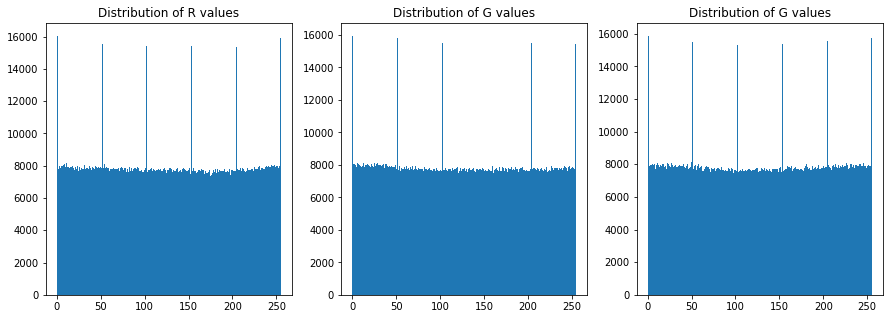

In [8]:
# Display the distribution of each value
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.hist(train_set_copy['r'], bins=250,)
plt.title("Distribution of R values")
plt.subplot(1, 3, 2)
plt.hist(train_set_copy['g'], bins=250,)
plt.title("Distribution of G values")
plt.subplot(1, 3, 3)
plt.hist(train_set_copy['b'], bins=250)
plt.title("Distribution of G values")

pass

Aside from a few values being extremely more common than most, perhaps due to randomness or the design of the study, the R G B values are uniformly distributed with each value occuring around 8000 times. We also verified that the values only range from 0 to 255 because of the contraints on the RBG color system. 

Additional features that would be helpful are the average value between the rgb values. Another value that would be helpful is the 'closeness' between each value. This is because colors like gray white and black are harder to distinguish, but their values are all the same.

In [9]:
#creating a method to make an attribute called mean_rgb_value that is the average of all 3 values for each color
def add_mean_column(colors):
  colors["mean_rgb_value"] = ((colors["r"] + colors["g"] + colors["b"]) / 3)
  return colors



#Creating another method that based on the given rgb values can produce h s and v values for the color
def add_hsv_columns(colors):
  colors['h'] = 0
  colors['s'] = 0
  colors['v'] = 0
  
  i = 2
#   while i < colors['r'].count():
#     if (colors['r'][i] == i).any():
#       colors['h'][i], colors['s'][i], colors['v'][i] = colorsys.rgb_to_hsv(colors['r'][i], colors['g'][i], colors['b'][i])
#     i = i + 1
#   return colors
  
  
  
#Creating another method that based on the given rgb values can produce a closeness value for the color
def add_closeness_column(colors):
    train_set_copy['closeness'] = (train_set_copy["r"] + train_set_copy["g"]) / train_set_copy["b"]
    colors.fillna(0)
    return colors


#train_set_copy = add_hsv_columns(train_set_copy)
train_set_copy = add_mean_column(train_set_copy)
train_set_copy = add_closeness_column(train_set_copy)

train_set_copy[:10]

,r,g,b,colorname,mean_rgb_value,closeness
862339,222,53,57,red,25.333333,0.333333
1880858,99,237,93,washed out green,57.666667,0.860215
2376045,255,161,193,pink,32.333333,0.829016
1424253,232,210,4,ugly yellow,63.333333,46.500000
2487561,163,112,207,pastel purple,75.333333,0.091787
995171,245,236,52,yellow,7.000000,4.326923
779189,98,53,3,brown,51.333333,50.333333
1398671,189,99,105,mauve,45.666667,0.304762
1586048,207,254,153,yellow green,34.000000,1.339869
2417423,210,187,208,pale mauve,31.000000,0.677885


This attribute may or may not be useful, we will verify that in a later step. Because the rgb values are uniformly distributed, the average will also be uniformly distributed.

The classifier struggles when classifying white gray and black as I discussed in the bottom, so I am creating a closeness attribute

Summary Notes From Above
-----
Features:
* r
* g
* b

Because each attribute is uniformly distributed and this is a classification problem, we cannot compare correlations like in similar projects.


Extra Features to be used: 
* mean rgb value
* closeness

Transforms:
* MinMaxScaler- to make sure the value is between 0 and 255 for each attribute (not 100% necessary because all values are already in that range in the training set)
* StandardImputer - replace NaN values in the data set (not 100% necessary because there are none in the training set)
* Creating the new columns I discussed

Transfomations to make:
* "dont use" - say which colors should not be used and remove them from the dataset
* "remove below n" - specify a number and remove all the datapoints for color names that appear less than n times.

Prepare the Data
-------------------

**Data cleaning:** While the data has been significantly cleaned, it is still messy. There are several considerations you might want to make for the cleaning step:

* How many times should a colorname have come up (out of 2.5 million) for it to be a common-enough colorname? Right now only completely unique names have been removed. Should the color "toei asakusa line pink" that was given for 2 colors really be used? A function is proivded for you that removes all colors that have below a specified count. You will want to wrap this in a transformer and make the count a hyperparameter so you can find the best cutoff.
* The most common colors like green, blue, and purple (each with about 200k samples, in total about 25% of the data is these 3 colors) are likely not the best choices. We have lots of other choices for these colornames (forest green, sky blue, ...). Having a few classes that are so much more represented than the others will confuse most ML algorithms. You can remove specific colors from the dataset by using something similar to the following code:
```
dont_use = [...]
colors = colors[~colors.colorname.isin(dont_use)]
```
You will likely want to make the colors to not use a hyperparameter as well since later on your may find that some colors are over-represented in the outputs. Eliminating some of these colors will also make the dataset smaller which is nicer right now due to memory constrains. The flipside to all of this is that some RGB triplets may only be close to one of these common colors and removing them can cause gaps in the data.

**Feature engineering:** As mentioned in the exploration step, there are some possible features you may want to extract from the currently available features.

**Feature scaling:** Many ML algorithms prefer scaled data. However, our data is uniformly distributed which means the `StandardScaler` is not a good choice. There is another scaler that is commonly used that you will want instead (or you could just do it manually, its really easy in this case).

Remember to make this a complete pipeline so you can use the `GridSearchCV` and/or `RandomSearchCV`.

In [10]:
from sklearn.utils.metaestimators import if_delegate_has_method
class SupervisedPipeline(BaseEstimator):
  """
  This meta estimator wraps the entire process of preprocessing the data
  including allowing removal of rows containing bad data across the data and
  target for a supervised system and then splitting the target value from the
  data and finally training the model.
  """
  def __init__(self, train_preprocessor, label_column, preprocessor, estimator=None):
    """
    train_preprocessor - transformer, this preprocessor is only run on the full
                    dataset (i.e. X and y combined) and only during training.
                    The goal of this preprocessor should be to only remove rows
                    of data across both the data and labels. The result after
                    this transform should be data that is compatible with the
                    regular preprocessor that the testing data goes through
                    except that it also includes the label_column which will be
                    removed next.
    label_column  - the string name or the integer index of the column that
                    contains the label information (y).
    preprocessor  - transformer, likely a Pipeline or ColumnTransformer, that
                    performs all preprocessing on the data without the labels. 
                    It is used for both training and testing.
    estimator     - classifier or regressor that makes predictions. Can be None
                    in which case this class acts as a transformer.
    
    Overall training process (i.e. fit):
      Xt = train_preprocessor.fit_transform(X)
      y  = split off label_column from Xt
      Xt = preprocessor.fit_transform(Xt, y)
      estimator.fit(Xt, y)
      
    Overall testing process (i.e. predict and similar):
      Xt = preprocessor.transform(X)
      return estimator.predict(Xt)
      
      
    All of the standard Sklearn estimator methods are supported as long as they
    are supported by the given estimator. They can all take Xy datasets.
    The fit and score methods can take X and y separately and the prediction
    methods can take just X datasets.
    """
    super().__init__()
    self.train_preprocessor = train_preprocessor
    self.label_column = label_column
    self.preprocessor = preprocessor
    self.estimator = estimator
    
  @staticmethod
  def __fit_transform(trans, X, **fit_params):
    return trans.fit_transform(X, **fit_params) if hasattr(trans, 'fit_transform') else trans.fit(X).transform(X, **fit_params)

  def __split(self, X):
    """Splits the label column from the data"""
    if isinstance(X, pd.DataFrame):
      col = X.columns[self.label_column] if isinstance(self.label_column, int) else self.label_column
      y = X.loc[:,col]
      X = X.drop(columns=col)
    else:
      y = X[:,self.label_column]
      X = np.delete(X, self.label_column, 1)
    return X, y
  
  def __join(self, X, y):
    """Joins the label column into the data"""
    if isinstance(X, pd.DataFrame):
      X.insert(self.label_column if isinstance(self.label_column, int) else len(X.columns), self.label_column, y)
      Xy = X
    else:
      Xy = np.insert(X, self.label_column, y, axis=1)
    return Xy

  def __fit(self, X, y=None, **fit_params): # TODO: deal with fit_params like in Pipeline
    Xy = self.__join(X, y) if y is not None else X
    Xt = SupervisedPipeline.__fit_transform(self.train_preprocessor, Xy)
    Xt, y = self.__split(Xt)
    self.final_X_cols_ = Xt.shape[1]
    Xt = SupervisedPipeline.__fit_transform(self.preprocessor, Xt)
    return Xt, y, {}

  def fit(self, X, y=None, **fit_params):
    Xt, y, fit_params = self.__fit(X, y, **fit_params)
    if self.estimator is not None:
      if isinstance(Xt, pd.DataFrame): Xt = Xt.reset_index(drop=True)
      self.estimator.fit(Xt, y, **fit_params)
    return self
  
  @if_delegate_has_method(delegate='estimator')
  def fit_predict(self, X, y=None, **fit_params):
    Xt, y, fit_params = self.__fit(X, y, **fit_params)
    return self.estimator.fit_predict(Xt, y, **fit_params)
    
  @if_delegate_has_method(delegate='estimator')
  def predict(self, X, **predict_params):
    if X.shape[1] != self.final_X_cols_: X, _ = self.__split(X)
    if isinstance(X, pd.DataFrame): X = X.reset_index(drop=True)
    Xt = self.preprocessor.transform(X)
    return self.estimator.predict(Xt, **predict_params)

  @if_delegate_has_method(delegate='estimator')
  def predict_proba(self, X):
    if X.shape[1] != self.final_X_cols_: X, _ = self.split_xy(X)
    if isinstance(X, pd.DataFrame): X = X.reset_index(drop=True)
    Xt = self.preprocessor.transform(X)
    return self.estimator.predict_proba(Xt)

  @if_delegate_has_method(delegate='estimator')
  def predict_log_proba(self, X):
    if X.shape[1] != self.final_X_cols_: X, _ = self.split_xy(X)
    if isinstance(X, pd.DataFrame): X = X.reset_index(drop=True)
    Xt = self.preprocessor.transform(X)
    return self.estimator.predict_log_proba(Xt)

  @if_delegate_has_method(delegate='estimator')
  def decision_function(self, X):
    if X.shape[1] != self.final_X_cols_: X, _ = self.split_xy(X)
    if isinstance(X, pd.DataFrame): X = X.reset_index(drop=True)
    Xt = self.preprocessor.transform(X)
    return self.estimator.decision_function(Xt)

  @if_delegate_has_method(delegate='estimator')
  def score(self, X, y=None, sample_weight=None):
    if y is None: X, y = self.split_xy(X)
    Xt = self.preprocessor.transform(X)
    if isinstance(Xt, pd.DataFrame): Xt = Xt.reset_index(drop=True)
    score_params = {}
    if sample_weight is not None: score_params['sample_weight'] = sample_weight
    return self.estimator.score(Xt, y, **score_params)
  
  @property
  def transform(self):
    if self.estimator is None: return self._transform
    raise AttributeError('transform not available when there is an estimator')
  def _transform(self, X):
    if X.shape[1] != self.final_X_cols_: X, _ = self.split_xy(X)
    return self.preprocessor.transform(X)
  
  @property
  def fit_transform(self):
    if self.estimator is None: return self._transform
    raise AttributeError('fit_transform not available when there is an estimator')
  def _fit_transform(self, X, y=None, **fit_params):
    Xt, _, _ = self.__fit(X, y, **fit_params)
    return Xt
  
  # The remaining methods are not part of the standard sklearn system
  def split_xy(self, Xy):
    """
    Splits the Xy dataset into X and y. Performs any training preprocessing but
    not the full preprocessing (and no estimation).
    """
    return self.__split(self.train_preprocessor.transform(Xy))

  def transform_xy(self, Xy):
    """
    Splits and transforms the Xy dataset. Returns the X and y split datasets.
    Does not run estimation.
    """
    Xt, y = self.split_xy(Xy)
    return self.preprocessor.transform(Xt), y

  def fit_transform_xy(self, X, y=None, **fit_params):
    """
    Fits this model to the Xy dataset while the data is split and transformed.
    Returns the X and y split datasets. The estimator is fit but does not effect
    the return values.
    """
    Xt, y, fit_params = self.__fit(X, y, **fit_params)
    if self.estimator is not None:
      if isinstance(Xt, pd.DataFrame): Xt = Xt.reset_index(drop=True)
      self.estimator.fit(Xt, y, **fit_params)
    return Xt, y


Since there are still many misspellings of colors due to human error, and also some very specific names that are not very useful, I will use remove_colors_below_count,  this will remove the different colors that appear below n times, I am setting n to 300. This should limit the training data to more common color names

In [11]:
def remove_colors_below_count(colors, n):
  """
  Returns a new dataframe with all colors removed that show up less than n
  times.
  """
  counts = colors.colorname.value_counts()
  return colors[colors.colorname.isin(counts[counts>=n].index)]

In [12]:
train_set_copy = remove_colors_below_count(train_set_copy, 300)

Because when labels appear many many more times times in a data set it will cause problems for the sysyem, I am removing three of the extremely common values. green, blue and purple all appear around 200,000 times each, while the next most common is nowhere near that many. This should not affect the data too much because while there may be many of those three colornames, there are more specific labels for these too like light and dark green that can fill in for the generics. Depending on what the client wants, specific names may be more useful than these generic ones. (good question to ask if we could talk to the client)

In [13]:
def dont_use_colors(colors, dont_use=[]):
  """
  Returns a new dataframe with all colors removed that are specified in the list
  """
  return colors [~colors.colorname.isin(dont_use)]

In [14]:
train_set_copy = dont_use_colors(train_set_copy, ['green', 'blue', 'purple'])

In [15]:
#Running this to check if the green, blue and purple (the specified color names) datapoints were removed.
train_set_copy.colorname.value_counts()[:10]

pink           79221
brown          45331
red            40768
teal           39629
light blue     36719
gray           32315
orange         32097
light green    30208
magenta        29180
yellow         27004
Name: colorname, dtype: int64

Because we will need both of these transformations in the pipeline, they both need to be made into a class called I am calling "RemoveBadData" which does the steps in remove_colors_below_count and dont_use_colors. This makes it much simpler when adding the testing set or different data.

In [16]:
class RemoveBadData(BaseEstimator, TransformerMixin):
  """
Removes specific colors from the data based on the names provided in the dont_use list, and removes colors with counts below n.
  """
  def __init__(self, n, dont_use=[]):
    super().__init__()
    self.dont_use = dont_use
    self.n = n
  
  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    X1 = dont_use_colors(X, self.dont_use)
    X2 = remove_colors_below_count(X1, self.n)
    return X2

Because the data given into the system is only R G and B values, we need a step in the pipeline that will calculate the mean rgb value from them. This means we need a class to create these values because they are not provided.

In [17]:
class CreateMeanRGBValue(BaseEstimator, TransformerMixin):
  """
  Transformer that takes the existing RGB values averages them to create the mean_rgb_value attribute
  """
  
  def __init__(self):
    super().__init__()
    
  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    X1 = add_mean_column(X)
    return X1

The same thing goes for closeness

In [18]:
class CreateCloseness(BaseEstimator, TransformerMixin):
  """
  Transformer that takes the existing RGB values makes a value for 'closeness' which is the diference in 2 divided by the third
  """
  
  def __init__(self):
    super().__init__()
    
  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    X1 = add_closeness_column(X)
    return X1

In [19]:
class ConvertToHSV (BaseEstimator, TransformerMixin):
  """
  Transformer that takes the existing RGB values and creates 3 new attributes for the HSV values of the color
  """
  
  def __init__(self):
    super().__init__()
    
  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    X1 = add_hsv_columns(X)
    return self

Because the dataset is so large, I am creating a sample that is 5% of the original training set. This will be used for quickly training rougher classifiers in the next step so it goes much faster. **This dataset Includes all the transformations I have done above and should not be used in the next step**.

In [20]:
transformed_colors_sample = train_set_copy.sample(frac=0.05)

Similarly, because the dataset is so large, I am creating a sample that is 5% of the original training set. This will be used for quickly training rougher classifiers in the next step so it goes much faster. **This is the unchanged data to be run through the full supervised pipeline and the rest of the process**

In [21]:
colors_sample = train_set.sample(frac=0.05)

The show_examples and show_errors  methods help to judge the quality of the models being used, but show_errors cannot be blindly trusted because if a color is classified correctly but not the exact name it is supposed to have it is technically incorrect.

In [22]:
def show_examples(cls_pipeline):
  """
  Shows a quick few examples of colors and their predictions to get a
  visualization of where errors are being made. Feel free to adjust which
  RGB triplets are being used below.
  
  The argument given must be a full pipeline that has a predict method that
  takes a DataFrame of RGB triplets. Must be fit already.
  """
  test_colors = [
    [255, 0, 0], [255, 255, 0], [0, 255, 0], [0, 255, 255], [0, 0, 255], [255, 0, 255],
    [128, 0, 0], [128, 128, 0], [0, 128, 0], [0, 128, 128], [0, 0, 128], [128, 0, 128],
    [255, 255, 255], [128, 128, 128], [0, 0, 0]
  ]
  test_colors_df = pd.DataFrame(test_colors, columns=('r','g','b'), dtype=np.uint8)
  predictions = cls_pipeline.predict(test_colors_df)
  for i,color in enumerate(test_colors):
    plt.subplot(3, 5, i+1)
    plt.title(predictions[i])
    plt.imshow([[color]])
    plt.axis('off')

In [23]:
def show_errors(cls_pipeline, validation, correct_color='green', correct_alpha=0.1, incorrect_color='red', incorrect_alpha=0.01):
  """
  Shows correct samples and mistakes that the clsasifier makes on the given
  set of validation colors. The validation coloes are a DataFrame of RGB
  triplets and the colornames.
  """
  predictions = cls_pipeline.predict(validation[['r','g','b']])
  correct_x, correct_y, correct_z = [], [], []
  incorrect_x, incorrect_y, incorrect_z = [], [], []
  for prediction,(r,g,b,colorname) in zip(predictions, validation.values):
    if prediction == colorname:
      correct_x.append(r), correct_y.append(g), correct_z.append(b)
    else:
      incorrect_x.append(r), incorrect_y.append(g), incorrect_z.append(b)
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.scatter3D(correct_x, correct_y, correct_z, c=correct_color, alpha=correct_alpha)
  ax.scatter3D(incorrect_x, incorrect_y, incorrect_z, c=incorrect_color, alpha=incorrect_alpha)
  ax.set_xlabel('r')
  ax.set_ylabel('g')
  ax.set_zlabel('b')

This preprocessor will create all the added attributes I have discussed throughout this document based on the RGB values, then it will fill values which are missing with the median and make sure all values are scaled to be between 0 and 255. No data in the training set is missing or not between these bounds, but it is still useful in case data is added that does not fit these constraints.

In [24]:
def create_preprocessor():
  num_attrs = ['r', 'g','b']
  

  num_trans = Pipeline(steps=[
    ('make_closeness_attr', CreateCloseness()),
    ('make_mean_attr', CreateMeanRGBValue()),
   # ('make_hsv_columns', ConvertToHSV()),  
    ('imputer', SimpleImputer(strategy='median')),
    ('standarization', MinMaxScaler(feature_range=(0, 255))),
  ])
  

  preprocessor = ColumnTransformer(transformers=[
    ('num', num_trans, num_attrs)
  ])
  
  return preprocessor

To use the data in each model we need to seperate the feature values and target names as seperate variables.

In [25]:
# Get the feature values and target values as separate variables
X = colors_sample[['r', 'g', 'b']]
y = colors_sample.colorname

In [26]:
#Creating the preprocessor to be used in the Supervised pipeline
preprocessor = create_preprocessor() 

This is the supervised pipeline which combines the preprocessor with the scaler, imputer and creating new features with the remove bad data method/class

In [27]:
pipeline = SupervisedPipeline(
    RemoveBadData(300, ['green', 'purple', 'blue']), 
    "colorname",        # column with label
    preprocessor,    # cleans data and extracts features
    
)

With the preprocessing taken care of we can begin training a couple models.

Short-List Promising Models
---------------------------------

We have learned several models that could work with our data. Time for you to try them out to see which ones appear to work the best with minimal tweaking of their hyperparameters. Evaluate their training performance and their generalization performance. You will likely have to use a small subset (50-100k samples) for this to not run out of memory.

Make sure to go through the following from the checklist:
1. Train many quick and dirty models from different categories using standard hyperparameters
2. Measure and compare their performance. For each model, use $N$-fold cross-validation and compute the mean and standard deviation of the performance measure on the $N$ folds.
3. Analyze the most significant variables (hyperparameters) for each algorithm
4. Analyze the types of errors the models make. What data would a human have used to avoid these errors?
5. Have a quick round of feature selection and engineering
6. Have one or two more quick iterations of the five previous steps (which include trying the different models)
7. Short-list the top three* most promising models, preferring models that make different types of errors

For a complete answer to this part you must list your top 2 models and why you are selecting them, answering questions from above about them.

***NOTE***: Only one classifier we have seen so far supports online learning: Stocastic Gradient Descent. Luckily, it can 'emulate' some of the other classifiers. When using the SGD Classifier, use it in an online manner and train against the entirety of the training data (not just 50-100k samples). To do this you need to use the `partial_fit` method in a loop, giving it chunks of the dataset at a time. The first time this method is called you need to provide it a list of all possible classes. After that it works like the standard `fit` method. I will provide an example of using this function shortly.

Fitting the data with the pipeline to be used in the models

In [28]:
pipeline.fit(colors_sample)
X,y = pipeline.transform_xy(colors_sample)

I will run through the same process with a few classifiers, what I take away from each step is described at the end of each classifier section to be more consise. Training the classifier, running a crossval score for the f1 score, checking the errors graph and then the examples.

First I will be training a decision tree classifier

In [29]:
#Training a DecisionTreeClassifier on the smaller sample of testing data
dt_clf = DecisionTreeClassifier()

f1 score is a good metric to use to measure the quality of this model because it balances the metrics precision and recall. The client never specified any specific goals of the program so f1 score is an all around balanced metric. I will be using f1 score to measure all of these models justified with this same argument.

In [30]:
#running a cross val score 3 times to find the f1 score of this model. Takes a very long time.
cross_val_score(dt_clf, X, y, scoring='f1_micro', cv=3)

array([0.33947751, 0.34342734, 0.33781443])

In [31]:
dt_clf.fit(X, y).predict(pipeline.transform(colors_sample))

array(['sky blue', 'olive', 'pink', ..., 'orange', 'yellow', 'magenta'],
      dtype=object)

In [32]:
dt_pipeline = SupervisedPipeline(
    RemoveBadData(300, ['green', 'purple', 'blue']), 
    "colorname",        # column with label
    preprocessor,    # cleans data and extracts features
    dt_clf
    
)

dt_pipeline.fit(colors_sample)
pass

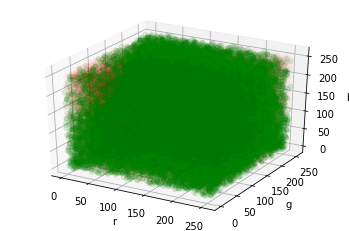

In [33]:
show_errors(dt_pipeline, colors_sample)

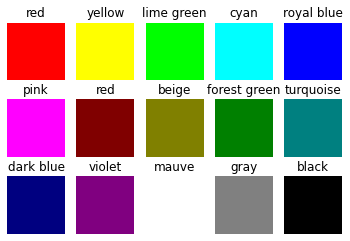

In [34]:
show_examples(dt_pipeline)

In [35]:
# Get the whole set feature values and target values as separate variables to use in the minibatch classifier
X_train = train_set[['r', 'g', 'b']]
y_train = train_set.colorname

This model pretty really well when classifying example data, but technically is only is getting about a third of the classifications correct each time. This may be because it was only given a tiny sample of the training set or that it is yet to recieve fine tuning. Another wrinkle is that there are many different color names that one color could be classified as, and it may even look right while not being the "correct" one. This is the case when looking at the example set, all the colors look correct but are not the specific colorname they may have started with making them show up as red on show_errors. Common errors this makes is with red, white and gray.


This will most likely be one of the classifiers I will bring into the next step or possibly include in an ensemble of diverse models. 

Next I will be training a Random Forest Classifier

In [36]:
 #Training a RandomForestClassifier on the smaller sample of testing data
rf_clf = RandomForestClassifier(n_estimators=70, max_depth = 3, min_samples_leaf=300, n_jobs=-1)
rf_clf.fit(X, y)
#Running a corss val score to determine the f1 score of this model
cross_val_score(rf_clf, X, y, scoring='f1_micro', cv=3)

array([0.34141778, 0.3498718 , 0.31744162])

In [37]:
rf_pipeline = SupervisedPipeline(
    RemoveBadData(300, ['green', 'purple', 'blue']), 
    "colorname",        # column with label
    preprocessor,    # cleans data and extracts features
    rf_clf
    
)

rf_pipeline.fit(colors_sample)
pass

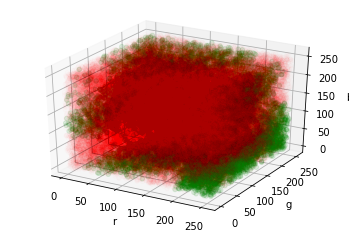

In [38]:
show_errors(rf_pipeline, colors_sample)

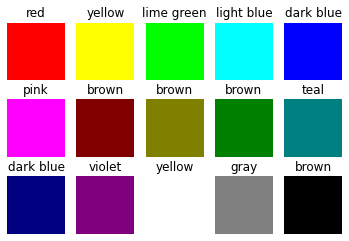

In [39]:
show_examples(rf_pipeline)

This model does a fairly good job classifying the data, but it calls too many colors blue purple and green and brown. This probably means the colors appear too many times in the data and should be removed to stop skewing the classifier. The f1 score is around .33 which is fairly good considering that only takes the specific correct name into account as discussed in the last classifier. One thing this classifier and the decision tree both struggle with is white gray and blacks. One error specific to this classifier is classifying too many colors as brown.

This would be a good piece of an ensemble with different classifiers which make different errors.

In [40]:
from sklearn.base import BaseEstimator, ClassifierMixin
class MiniBatchClassifier(BaseEstimator, ClassifierMixin):
  def __init__(self, clf, n_iter=5, mini_batch_size=25000):
    """
    clf is the underlying classifier to use, it must have a partial_fit method
    n_iter is the number of iterations to go through all data samples
    mini_batch_size is how much data will be given to partial_fit at a time
    """
    self.clf = clf
    self.n_iter = n_iter
    self.mini_batch_size = mini_batch_size
  def fit(self, X, y):
    # Performs mini-batches
    import random
    # Convert args and setup basic information
    X = np.asanyarray(X)
    y = np.asanyarray(y)
    classes = np.unique(y)
    indices = list(range(len(X)))
    for iter in range(self.n_iter):
      # Shuffle the indices of the data
      random.shuffle(indices)
      for mb_start in range(0, len(indices), self.mini_batch_size):
        # Train on a mini batch
        inds_mb = indices[mb_start:mb_start+self.mini_batch_size]
        X_mb = X[inds_mb]
        y_mb = y[inds_mb]
        self.clf.partial_fit(X_mb, y_mb, classes=classes)
    return self
  # Rest of the functions just defer to the trained classifier
  def predict(self, X): return self.clf.predict(X)
  def predict_proba(self, X): return self.clf.predict_proba(X)
  def predict_log_proba(self, X): return self.clf.predict_log_proba(X)
  def decision_function(self, X): return self.clf.decision_function(X)
  def score(self, X, y, **kwargs): return self.clf.score(X, y, **kwargs)

The only model that supports online learning that we have learned about is the SGDClassifier. This means it can utilize the minibatch classifier, which would allow it to train on the full training set, not just a little sample.

In [41]:
#Training a SGD model using the minibatch classifier
sgd_clf = SGDClassifier() 
sgd_clf_mb = MiniBatchClassifier(sgd_clf)
sgd_clf_mb.fit(X, y)

MiniBatchClassifier(clf=SGDClassifier(alpha=0.0001, average=False,
                                      class_weight=None, early_stopping=False,
                                      epsilon=0.1, eta0=0.0, fit_intercept=True,
                                      l1_ratio=0.15, learning_rate='optimal',
                                      loss='hinge', max_iter=1000,
                                      n_iter_no_change=5, n_jobs=None,
                                      penalty='l2', power_t=0.5,
                                      random_state=None, shuffle=True,
                                      tol=0.001, validation_fraction=0.1,
                                      verbose=0, warm_start=False),
                    mini_batch_size=25000, n_iter=5)

I do not know if it's just a problem with my computer or if I wrote something incorrectly, but using the minibatch classifier on the entire dataset does not work, it just runs forever. I let it run for a half hour and it did not stop. It would be interesting to see if training on the entire training set helped performance, but I cannot. That being said I will just be using the sample training set and not the minibatch classifier.

In [42]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [43]:
sgd_pipeline = SupervisedPipeline(
    RemoveBadData(300, ['green', 'purple', 'blue']), 
    "colorname",        # column with label
    preprocessor,    # cleans data and extracts features
    sgd_clf
    
)

sgd_pipeline.fit(colors_sample)
pass

In [44]:
#running a cross val score 3 times to find the f1 score of this model
cross_val_score(sgd_clf, X, y, scoring='f1_micro', cv=3)

array([0.06700852, 0.06964174, 0.21620123])

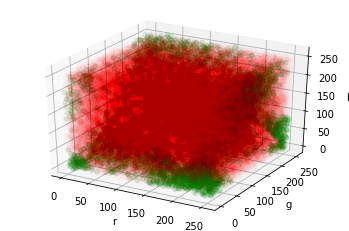

In [45]:
show_errors(sgd_pipeline, colors_sample)

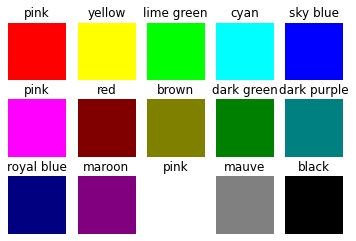

In [46]:
show_examples(sgd_pipeline)

This model Is the worst so far and does not seem to do well classifying the data, only getting an f1 score of around 0.1 . While this is because there are many different color names that one color could be classified as and look right while not being the "correct" one, this is also because the system is not fully refined yet and was only given a sample of the training set, not all the data. Because the SGD model is one of the only ones we have studied that supports online learning, if that is what the client wanted I would have to contine with this model in the next step. 


This classifier is very good at classifying colors near the verticies of the graph, where 2 values are high and one is low. 

All of this being said, one easy way to greatly increase the effectiveness of this model is tweaking the hyperparameters becuse an sgdclassifier has so many of them. The performance of this model is already so low however, and the minibatches aren't working, so I will not be continuing with it.

Because each model, and this one in particular, seem to be struggling when classifying gray, white and black, I am going back up to preparing the data to create a "closeness" attribute. This is because these three problem colors all have the same r g and b values and would be very close. 

Fine-Tune the System
-------------------------

Run a `GridSearchCV`  and/or `RandomSearchCV` on your top 2 models from the last step obtaining the best values for the hyperparameters (including any you set up specifically for this dataset).

My decision tree classifer performed the best out of any of the models I used, so I will continue with that one and try to make refine the hyperparameters to fine tune the system

Running a gridsearch on the decision tree classifier to find the best values for max depth and min samples leaf. These values are very important when dealing with decision trees and random forests (and extra trees) because they heavily determine the regularization of the model and can reduce overfitting.

In [47]:
pipeline = SupervisedPipeline(RemoveBadData(300, dont_use=['purple', 'blue', 'green']), "colorname", preprocessor, dt_clf)

param_grid = {'estimator__max_depth': [2, 3, 4, 5],
    'estimator__min_samples_leaf': [10, 50, 300, 400, 500]
}

dt_opt = GridSearchCV(pipeline, param_grid, cv=2)
dt_opt.fit(*pipeline.split_xy(train_set)) # magic here!

GridSearchCV(cv=2, error_score=nan,
             estimator=SupervisedPipeline(estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                           class_weight=None,
                                                                           criterion='gini',
                                                                           max_depth=None,
                                                                           max_features=None,
                                                                           max_leaf_nodes=None,
                                                                           min_impurity_decrease=0.0,
                                                                           min_impurity_split=None,
                                                                           min_samples_leaf=1,
                                                                           min_samples_split=2,
             

In [48]:
dt_opt.best_params_

{'estimator__max_depth': 5, 'estimator__min_samples_leaf': 10}

Doing another gridsearch with values ranging closer to the 'best_params_' trying to find if there is are better values for each.

In [49]:
pipeline = SupervisedPipeline(RemoveBadData(300, dont_use=['purple', 'blue', 'green']), "colorname", preprocessor, dt_clf)

param_grid = {'estimator__max_depth': [5, 10, 15],
    'estimator__min_samples_leaf': [5, 10, 20]
}

dt_opt = GridSearchCV(pipeline, param_grid, cv=2)
dt_opt.fit(*pipeline.split_xy(train_set)) # magic here!

GridSearchCV(cv=2, error_score=nan,
             estimator=SupervisedPipeline(estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                           class_weight=None,
                                                                           criterion='gini',
                                                                           max_depth=None,
                                                                           max_features=None,
                                                                           max_leaf_nodes=None,
                                                                           min_impurity_decrease=0.0,
                                                                           min_impurity_split=None,
                                                                           min_samples_leaf=1,
                                                                           min_samples_split=2,
             

In [50]:
dt_opt.best_params_

{'estimator__max_depth': 10, 'estimator__min_samples_leaf': 20}

Repeating the process described in the cells above

In [51]:
pipeline = SupervisedPipeline(RemoveBadData(300, dont_use=['purple', 'blue', 'green']), "colorname", preprocessor, rf_clf)

param_grid = { 'estimator__max_depth': [9, 10, 11],
               'estimator__min_samples_leaf': [20, 30, 40]
}

rf_opt = GridSearchCV(pipeline, param_grid, cv=2)
rf_opt.fit(*pipeline.split_xy(train_set)) 

KeyboardInterrupt: ignored

Running a grid search to refine the random forest model. I am changing the min_samples_leaf and max_size hyperparameters. This takes a long time.

With the hyperparameters optimized we can run our final model and see how effective it is.

In [52]:
dt_clf = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 20)
cross_val_score(dt_clf, X, y, scoring='f1_micro', cv=3)

array([0.43850045, 0.43579794, 0.42831405])

In [53]:
dt_pipeline = SupervisedPipeline(
    RemoveBadData(300, ['green', 'purple', 'blue']), 
    "colorname",        # column with label
    preprocessor,    # cleans data and extracts features
    dt_clf
    
)

dt_pipeline.fit(colors_sample)
pass

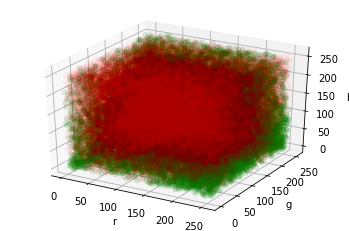

In [54]:
show_errors(dt_pipeline, colors_sample)

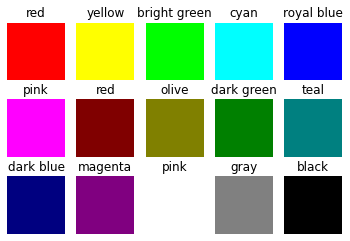

In [55]:
show_examples(dt_pipeline)

This model has become much better at classifying the colors, going from an f1 score of 0.3 to almost 0.5. Looking at the examples, the classifier is doing much better on all colors except ocasionally white. The system still struggles with colors with similar RGB values, (the middle of the graph), but it is much better than before.

Now that we are at the very end of the process we can finally asses the system on the testing set.

In [56]:
#Cutting the test set in half because it is a little too big and can crash my runtime. 
#Ideally I would rather use the 20% but it is not possible with my current setup. I gradually would increase it until the RAM got close to using too much
#I know this is not ideal either but it seemed to be a different size that crashed the program each time, seems like a google colab eccentricity and not my own error
test_set = test_set.sample(frac=0.5)

In [ ]:
# Get the feature values and target values as separate variables for the test set
from sklearn.metrics import f1_score

X_test = test_set[['r', 'g', 'b']]
y_test = test_set.colorname
test_pred = dt_clf.fit(X_test, y_test).predict((X_test))
f1_score(y_test, test_pred, average='micro')

The f1 score is a bit lower than on the training set, this is because we are overfitting a little bit. Overall this is much better than before. Depending on what the business declared good enough this could be refined a bit more.

Present Your Solution
-------------------------

Document what you have done and mention what your final solution is and how well it works.

AI oriented description of what I did

The goal of this assignment was to use data from a RGB-based color survey to predict the color name when given an RGB triplet. After exploring the data I realized there were many transformations to put on the data. Because sometimes people are overly specific, wrote too unique of names, and sometimes had common spelling mistakes, I had to drop colornames that appeared less than 200 times to eliminate these. Also, this may sound counter-intuitive, but I had to drop colornames that were too comon and appeared too many times, because when something appear too often it can disrupt the machine learning system. It may seem almost wrong, but In this case, having too much data could be hurtful. I did both of these in the RemoveBadData class in the pipeline. I also added values for the closeness of all 3 RGB values and the average value in their own classes in the pipeline. From then I used a crossvalscore focusing on f1 score to compare each model. I continued on with the decision tree model. Using gridsearch I determined the optimal attributes for two key hyperparameters to increase the f1 score by a third. 


If I were to have a setup with more RAM, or at the very least more processing power, it would be possible to train on the whole sample data and have possibly a more accurate solution or try a more complex classifier like an ensemble or voting classifier.

Client oriented description of what I did

First I explored the data and determined what given data would be the most important. This is of course the RGB values which are given. From there I created a few other attributes that would help me later like the average value. My solution that is very accurate at determining primary, secondary and tertiary colors, but not as good at determining colors in the middle of the graph or with RGB values that match like gray white and black. (see graph below. Each axis is one value of the RGB triplet, green means it was correctly predicted, red is incorrect) .



In [ ]:
show_errors(dt_pipeline, colors_sample)

You have to take the 'on paper' performance with a grain of salt however, because the system is a little better than it looks. This is because when scoring the system it only takes into account one correct classification when there are many specific ones to be classified as. (Ex red vs bright red, dark red or blue vs teal) If I were to have better resourses with more processing power this solution could possibly be improved by using the full dataset instead of a small sample.